# Exploration of time series data - Yohann

### To do

* [ ] Harmonic regression? (linear gain factor) 
* [ ] Seasonal trend in residuals (make plot of residuals) 
* [X] Difference method for eliminating seasonality - Yohann 
* [X] Plot residuals remove seasonal + trend 
    * [ ] Test stationarity of residuals 
* [X] Find autocorrelation of residuals - Yohann
* [ ] Implement tests for residuals
    * [ ] check if residuals uncorrelated
    * [ ] check if residuals are dependent
    * [ ] check if residuals are gaussian
* [ ] Make model of time series based on results from noise tests (probably a stationary ARMA)

* [ ] Write report
    * [ ] Abstract
    * [ ] Introduction
    * [ ] Theory analysis
    * [ ] Data analysis
    * [ ] Discussion
    * [ ] Conclusion
    
#### Yohann
* [X] Data cleaning
    * [X] Remove initial NaNs in measurements
    * [X] Forward fill remaining NaNs
* [X] Difference method for eliminating seasonality
* [ ] MA(q) filtering
    * [ ] Why do they use 0.5 as a factor for first and last element of windowing function?
* [ ] Find autocorrelation of residuals

### Helpful articles
* [Differencing column of DF](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)
* [Exponential Smoothing and ARIMA processes](https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788)
* [MA filtering](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)
* [Working with Time Series](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html)
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet)
* []()

## Questions for Jorge

* [ ] Are the residuals we get using method S1 good? 
    * [ ] Test if variance is constant at different times (stationarity) --> Bartlett test
        * [ ] If not, we can still work with them, but mention it in report
    * [ ] Second seasonal difference
* [ ] Test for zero mean in residuals
* [ ] 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

* Skip first 55 rows as they are just text
* Skip last 6 rows as they are post june 2019
* Remove first two values because the are empty, and we do not want to use backward filling.
* Also drop column "Date Excel" as that is not of interest.

In [2]:
filepath = '/mnt/workspace/time_series/monthly_in_situ_co2_mlo.csv'
#filepath = '/home/yohannjs/Documents/school/tidsrekker/monthly_in_situ_co2_mlo.csv'

df = pd.read_csv(filepath, 
                 na_values=-99.99, 
                 skiprows=55, 
                 skipfooter=6)
df.drop([0, 1], axis=0, inplace=True)
df.reset_index(inplace=True)
df.drop(['Date Excel', 'index'], axis=1, inplace=True)
df.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  import sys


,Yr,Mn,Date,CO2[ppm],seasonally adjusted[ppm],fit[ppm],seasonally adjusted fit[ppm],CO2 filled[ppm],seasonally adjusted filled[ppm]
0,1958,3,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
1,1958,4,1958.2877,317.45,315.16,317.30,314.98,317.45,315.16
2,1958,5,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71
3,1958,6,1958.4548,NaN,NaN,317.24,315.14,317.24,315.14
4,1958,7,1958.5370,315.86,315.18,315.87,315.22,315.86,315.18


### Subplots with and without seasonal adjustment

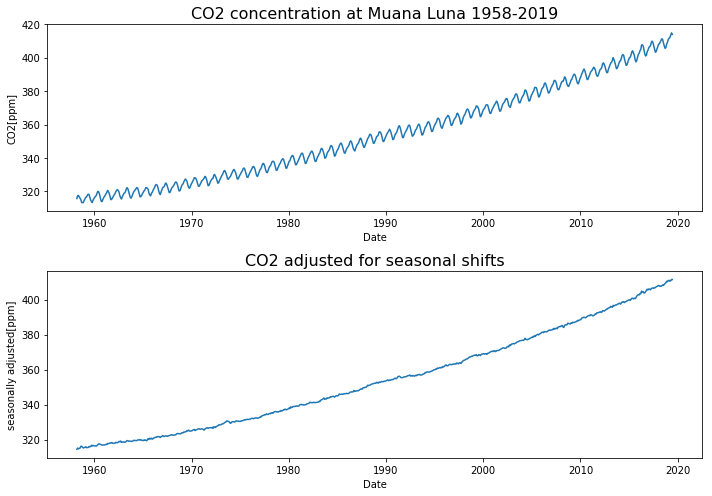

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,7))
g1 = sns.relplot(x='Date', y='CO2[ppm]', data=df, kind='line', ax=ax[0])
g2 = sns.relplot(x='Date', y='seasonally adjusted[ppm]', data=df, kind='line', ax=ax[1])

# You will have to close the additional empty figures returned by replot
plt.close(g1.fig)
plt.close(g2.fig) 

ax[0].set_title('CO2 concentration at Muana Luna 1958-2019', fontsize=16)
ax[1].set_title('CO2 adjusted for seasonal shifts', fontsize=16)

plt.tight_layout()

### Superplot with and without seasonal fit

## Applying method S2 difference method to estimate seasonal components

Making a clean dataframe with only the year, month, dates as floats and the unprocessed CO2 measurements. Since the time series starts with some missing values we backward fill to begin with (this needs to be changed to forward filling later). Then eliminate the seasonal component with differencing, and then eliminate the trend component.

In [51]:
co2DF = df[['Date', 'Yr', 'Mn', 'CO2[ppm]']].copy()
co2DF['co2'] = co2DF['CO2[ppm]']
co2DF.drop(['CO2[ppm]'], axis=1, inplace=True)
co2DF.fillna(method='ffill', inplace=True) # Forward filling the NaN values
co2DF.isnull().any()

Date    False
Yr      False
Mn      False
co2     False
dtype: bool

The equation below shows how we assume our time series is composed. We believe it to be an additative model where $m_t$ is the trend component, $s_t$ is the seasonal component and $Y_t$ are the residuals. 

\begin{equation}
    X_t = m_t + s_t + Y_t
    \label{eq:ts}
\end{equation}

Below we first eliminate the seasonal component by differencing with lag 12, as done in the equation below (1.5.2.1 in book) We do this since we believe the trend to be periodic by year, and the CO2 measurements are sampled monthly. 

\begin{align}
     X_{2t} &= \nabla_{12} X_t \\
     &= X_t - X_{t-12} \\
     &= (m_t + s_t + Y_t) - (m_{t-12} + s_{t-12} + Y_{t-12}) \\
     &= (m_t - m_{t-12}) + (s_t - s_{t-12}) + (Y_t - Y_{t-12})
\end{align}

After eliminating the seasonal component we continue with eliminating the trend component by differencing with lag one (1.5.2.2). 

In [59]:
co2DF['co2_seas_elim'] = co2DF['co2'] - co2DF['co2'].shift(12)
co2DF['co2_residuals'] = co2DF['co2_seas_elim'] - co2DF['co2_seas_elim'].shift(1)
co2DF.fillna(method='bfill', inplace=True) # Backward filling the newly generated NaN values

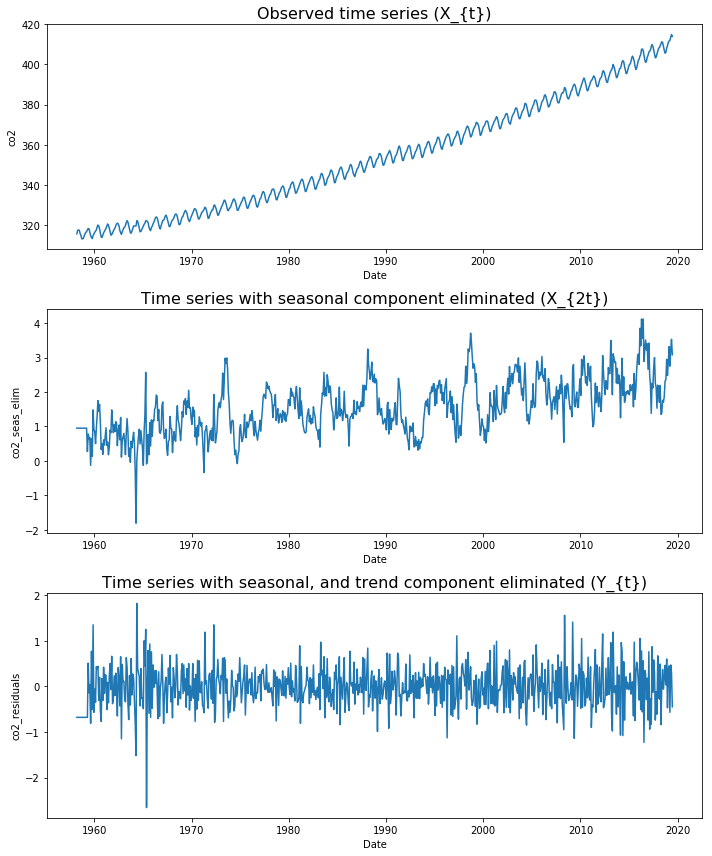

In [60]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
g1 = sns.relplot(x='Date', y='co2', data=co2DF, kind='line', ax=ax[0])
g2 = sns.relplot(x='Date', y='co2_seas_elim', data=co2DF, kind='line', ax=ax[1])
g3 = sns.relplot(x='Date', y='co2_residuals', data=co2DF, kind='line', ax=ax[2])

# Have to close the additional empty figures returned by relplot
plt.close(g1.fig)
plt.close(g2.fig) 
plt.close(g3.fig) 

ax[0].set_title('Observed time series (X_{t})', fontsize=16)
ax[1].set_title('Time series with seasonal component eliminated (X_{2t})', fontsize=16)
ax[2].set_title('Time series with seasonal, and trend component eliminated (Y_{t})', fontsize=16)

plt.tight_layout()

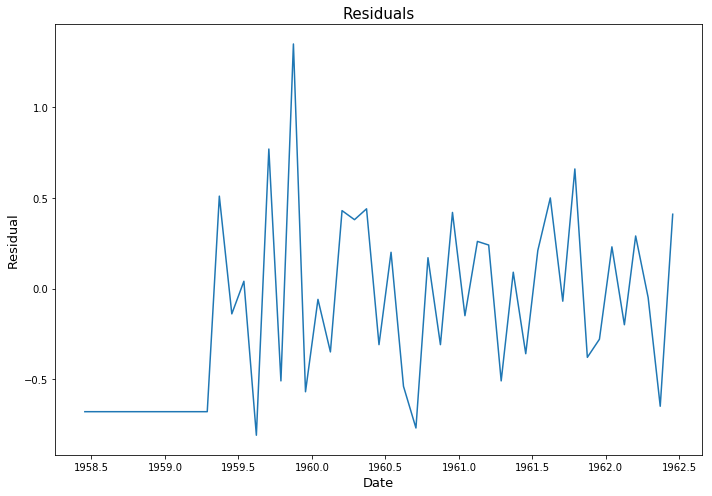

In [61]:
limm1 = 3
limm2 = 52
x = co2DF['Date'].values
y = co2DF['co2_residuals'].values

plt.figure(figsize=(10,7))
plt.plot(x[limm1:limm2], y[limm1:limm2])
plt.title('Residuals', fontsize = 15)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Residual', fontsize=13)
plt.tight_layout()

### Computing autocorrelation function

In [62]:
residuals = co2DF['co2_residuals']
residuals.isnull().sum()

0

In [82]:
def gen_autocorr(series):
    length_sequence = series.size
    lag = np.array(range(-length_sequence + 1, length_sequence))
    autocorr = np.correlate(series.values, series.values, mode='full')
    autocorr = autocorr / (autocorr[length_sequence - 1]) # Normalize with regard to lag = 0
    return pd.Series(lag), pd.Series(autocorr)

lag, autocorr_residuals = gen_autocorr(residuals)

## Plotting and performing tests

Text(0,0.5,'Correlation')

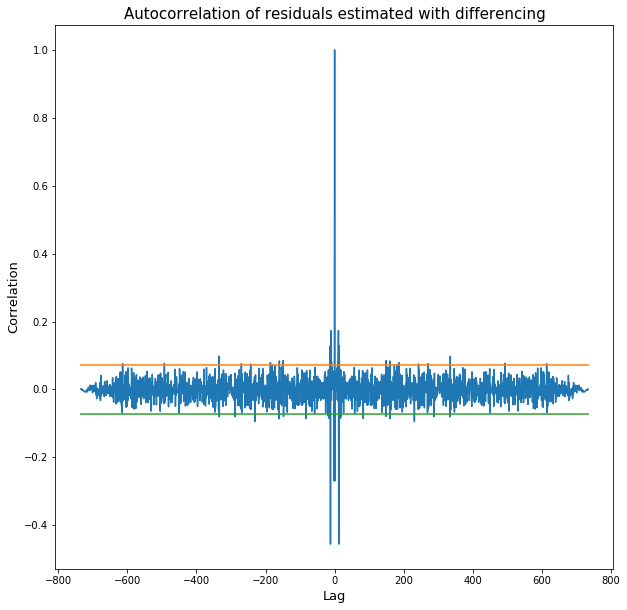

In [84]:
length_sequence = co2DF['co2_residuals'].size
# Boundarise
num = 1.96/np.sqrt(length_sequence)
upper = np.ones(2*length_sequence - 1)*num
lower = np.ones(2*length_sequence - 1)*(-num)

lim1 = 0
lim2 = -1

plt.figure(figsize=(10,10))
plt.plot(lag[lim1:lim2], autocorr_residuals[lim1:lim2], lag[lim1:lim2], upper[lim1:lim2], lag[lim1:lim2], lower[lim1:lim2])
plt.title('Autocorrelation of residuals estimated with differencing', fontsize = 15)
plt.xlabel('Lag', fontsize=13)
plt.ylabel('Correlation', fontsize=13)

### Autocorrelation test

According to book (page 30), if $Y_t$ is a realization of an i.i.d. process about 95% of the sample autocorrelation should fall between the range $\pm \frac{1.96}{\sqrt{736}} \approx \pm 0.0695$

In [85]:
nr_el_outside_range = 0
for i in range(autocorr_residuals.shape[0]):
    if np.abs(autocorr_residuals[i]) > num:
        nr_el_outside_range += 1

print('Number of sample autocorrelations outside boundary', nr_el_outside_range / (2*length_sequence-1) * 100, '%')

Number of sample autocorrelations outside boundary 3.059143439836846 %


Hence, from this test we cannot reject the hypothesis that the residuals are iid.

### Portmantau test

Instead of checking whether each sample of the autocorrelation $\hat{\rho}[h]$ falls inside the boundaries we calculate the sum:
$$
Q = n \sum_{j=1}^{h} \hat{\rho}^2[j]
$$
If $Y_t$ is a sequence of iid $N(0,1)$ random variables, $Q \rightarrow 0$ 

### Turning point test

### Difference-sign test

### The rank test

### Fitting an autoregressive model
Using the Yule-Walker algorithm

### Checking for normality